---
# Comparaison des algorithmes de classification
---

<center><img src="./img/mlprocess_3.png" alt="Processus d'apprentissage automatique" width="50%"/></center>

Une comparaison va être effectuée entre plusieurs classificateurs de la librairie Python SciKit-Learn sur des ensembles de données synthétiques. Le but de cet exercice est d'illustrer la nature des frontières de décision des différents algorithmes de classification. Faites attention cependant, les intuitions qui se dégagent des exemples pourraient ne pas se transférer sur des ensembles de données réels.

C'est particulièrement le cas avec des données de grande dimensionnalité; elles peuvent facilement être séparées linéairement. Ainsi, des algorithmes simples comme le Naive Bayes ou les SVMs linéaires peuvent donner de meilleurs résultats en termes de généralisation que ce que donneraient des algorithmes plus complexes ou avec plus de capacité. 

Les fonctions d'affichage vont présenter les données d'entraînement comme des points solides annotés de leur couleur. Les points de tests seront semi-transparents avec leur couleur "vraie" sous la forme d'un 'x'. La valeur en bas à droite de chaque figure donne la précision de l'algorithme sur l'ensemble de données de test.

Source des exemples : http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


In [1]:
%matplotlib inline

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Traduit et décomposé par Camille Besse
# License: BSD 3 clause
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

fg = (24,8)
cm_points = ListedColormap(['#FF0000','#FFFFFF', '#00FF00','#000000', '#0000FF'])
cm = 'jet_r'
params = {'figure.titlesize': 'xx-large',
          'font.size': '12',
          'text.color': 'k',
          'figure.figsize': fg,
         }
pylab.rcParams.update(params)



Automatically created module for IPython interactive environment


---
## Ensembles de données
---

Les trois ensembles de données que nous allons utiliser sont les suivants : 
- Les lunes
- Les cercles 
- Un ensemble linéairement séparable

Nous pouvons ajouter différents niveaux de bruits dans ces données. Voyons ce que ça donne.


In [2]:
# Paramètres initiaux des données : 
## Pour le générateur de nombres pseudo-aléatoires et la reproductibilité des résultats
rng_seed = 0 
## Le niveau de bruit dans les données (entre 0 et 0.5)
bruit = 0.0
# ---

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=rng_seed, n_clusters_per_class=2, flip_y=bruit/10,class_sep=2-2*bruit)
rng = np.random.RandomState(rng_seed)
X += bruit * 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

names = ["Lunes", "Cercles", "Séparables"]
datasets = [make_moons(noise=bruit, random_state=rng_seed),
            make_circles(noise=bruit/2, factor=0.5, random_state=rng_seed),
            linearly_separable
            ]

Affichons maintenant ces datasets:

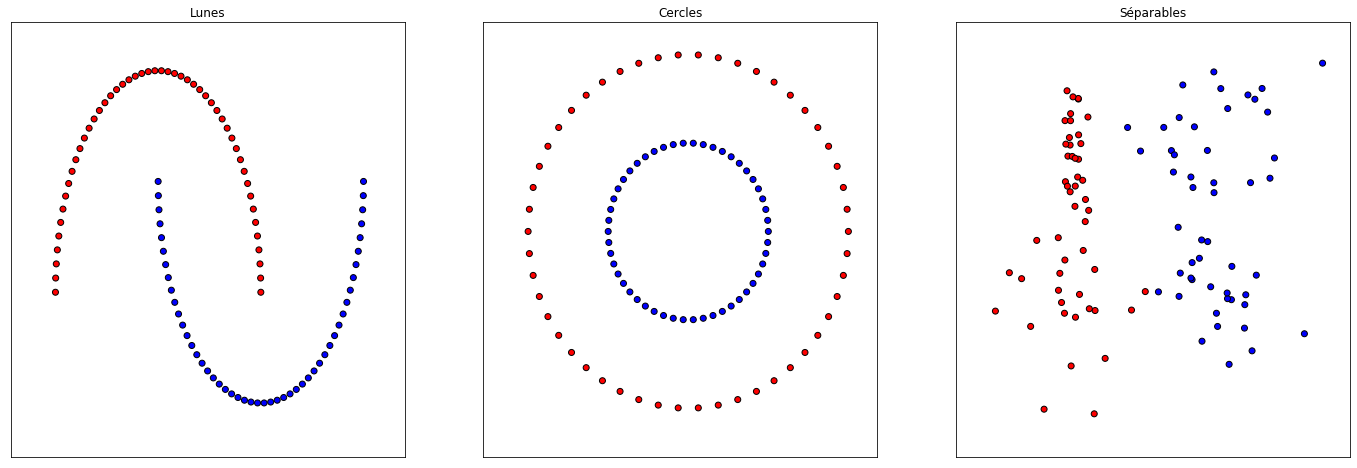

In [3]:
# Création des graphiques
figure = plt.figure(figsize=fg)
i = 1

# Pour chaque dataset (compteur, DataSet)
for ds_cnt, ds in enumerate(datasets):
    # Préparation rapide des données : normalisation des données et calcul des bornes 
    X, y = ds
    h = 0.2
    X = StandardScaler().fit_transform(X)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Visualisons le data set 
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(1, len(datasets), i)
    
    ax.set_title(names[ds_cnt])
        
    # Affichons les ensembles de données
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_points, edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    ## EXERCICE : Jouez avec les paramètres de bruit afin de voir leur effet dans les données

Définissons un ensemble de fonctions qui vont nous aider à visualiser plus simplement les résultats des différents classificateurs:

In [4]:
def creationMesh(X):
    """
    Crée une grille sur un espace bidimensionnel. Prends le min et le max de chaque dimension et 
    génère la grille avec une résolution de 0.02. 
    
    X: un vecteur à deux colonnes de données. 
    """
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx,yy


def plotClassifierOnData(name,clf,data,i=3,n=1,multi=False):
    """
    Pour afficher les résultats d'un classificateur sur un dataset
    name : le titre du graphique
    clf : le classificateur à utiliser
    data : les données à utiliser
    i : Le ième graphique sur n à afficher (pour afficher 3 graphiques par ligne)
    n : Le nombre total de graphiques à afficher
    multi: détermine si on affiche juste la frontière de décision (true) ou 
           le score/probabilité de chaque point de l'espace, car on ne peut afficher le score en multiclasse.
    """
    
    # Préparation rapide des données : 
    # Normalisation des données 
    X, y = data
    X = StandardScaler().fit_transform(X)
    # Séparation des données en TRAIN - TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=rng_seed)
    # Pour la visualisation des régions et calcul des bornes 
    xx,yy = creationMesh(X)

    # Création du bon nombre de figures à afficher (3 par lignes)
    ax = plt.subplot(n/3,3,i)
    
    # Entraînement du classificateur et calcul du score final (accuracy)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Pour afficher les frontières de décision, on va choisir une couleur pour 
    # chacun des points x,y du mesh [x_min, x_max]x[y_min, y_max].

    # Si on est en multiclasse (2 ou +), on affiche juste les frontières
    if multi:
         Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:# sinon on peut afficher le gradient du score
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # On affiche le mesh de décision
    Z = Z.reshape(xx.shape)
    test = ax.contourf(xx, yy, Z, 100, cmap=cm, alpha=.8)

    # On affiche la légende
    cbar = plt.colorbar(test)
    cbar.ax.set_title('score')
    
    # On affiche les points d'entraînement
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_points,
               edgecolors='k',s=100)
    # Et les points de test
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_points, 
               edgecolors='k',marker='X',s=100)

    # On définit les limites des axes et autres gogosses
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    ax.set_title(name,fontsize=22)
    # Dont le score en bas à droite
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')


def plotClassifier(name, clf, datasets):
    """
    Affiche pour un classificateur donné, son résultat sur l'ensemble des datasets préalablement déterminés
    name : le nom du classificateur à afficher (titre du graphique)
    clf : un classificateur de Scikit-Learn
    datasets : une liste de datasets
    """
    f = plt.figure(figsize=fg)
    # Pour chacun des dataSets
    for ds_cnt, ds in enumerate(datasets):
        plotClassifierOnData(name, clf, ds,ds_cnt+1,3)

    plt.tight_layout()
    plt.show()


---
## Algorithmes de classification
---

Voyons maintenant les différents algorithmes et leur(s) paramètre(s):

1. KNN
2. Arbre de décision
3. Random Forest
4. AdaBoost
5. Gradient Boosting
6. Régression logistique
7. Réseaux de neurones
8. SVM(s)
9. Processus Gaussiens


## 1. K-Nearest Neighbors (KNN) 

Ou les K plus proches voisins. 

[`sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Les principaux paramètres de la classe `sklearn.neighbors.KNeighborsClassifier` sont:
- `n_neighbors` : le nombre de voisins considérés
- `weights` : `uniform` (tous les poids sont égaux), `distance` (le poids est inversement proportionnel à la distance par rapport à l'échantillon testé) ou toute autre fonction lambda définie par l'utilisateur;
- `algorithm` : `brute`, `ball_tree`, `KD_tree` ou `auto`. Dans le premier cas, les voisins les plus proches pour chaque cas de test sont calculés par une recherche sur la grille de l'ensemble d'apprentissage. Dans les deuxième et troisième cas, les distances entre les exemples sont stockées dans un arbre pour accélérer la recherche des voisins les plus proches. Si vous définissez ce paramètre sur auto, la bonne façon de trouver les voisins sera automatiquement choisie en fonction du jeu d’entraînement.
- `leaf_size` : seuil pour passer à la recherche sur la grille si l'algorithme de recherche de voisins est `ball_tree` ou `KD_tree`;
- `metric` : fonction de calcul de la distance entre les points : `minkowski` (par défaut), `manhattan` (si `p`= 1), `euclidean` (si `p`= 2), `chebyshev` (si `p`= Infini). Attention, Scilik-Learn n'accepte pas p<1.

**Note :** La méthode souffre de la malédiction de la dimensionnalité. Pour des datasets de plusieurs millions de données dans de grandes dimensions, consultez [Annoy](https://github.com/spotify/annoy) la librairie de Spotify sur les K-NN approximés.

**Exercice :**  En utilisant le constructeur `NeighborsClassifier()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres pour comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

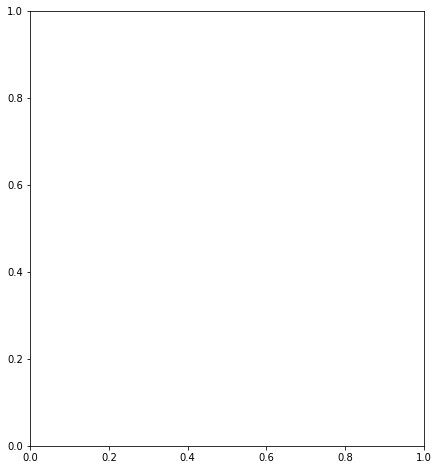

In [5]:
K = 3
w = 'uniform' #ou 'distance'

# Définir le modèle
model = ...
plotClassifier("K Nearest Neighbors", model, datasets)

## 2. Arbres de décision

[`sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Les principaux paramètres de la classe sklearn.tree.DecisionTreeClassifier sont les suivants:
- `max_depth` : la profondeur maximale de l'arbre;
- `max_features` : nombre maximal de caractéristiques permettant de rechercher la meilleure partition (nécessaire avec un grand nombre de caractéristiques, car il serait "coûteux" de rechercher des partitions pour toutes les caractéristiques);
- `min_samples_leaf` : nombre minimal d'échantillons dans une feuille. Ce paramètre empêche la création d’arbres où une feuille n’aurait que quelques membres.

Les paramètres de l’arbre doivent être définis en fonction des données d’entrée. Cette opération est généralement effectuée au moyen d’une validation croisée (vue ce matin).

**Exercice :**  En utilisant le constructeur `DecisionTreeClassifier()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

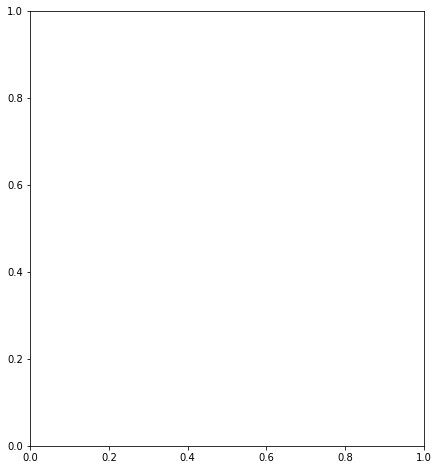

In [6]:
# Profondeur souhaitée de l'arbre de décision
profondeur = 15
# Règles sur une seule ou sur deux caractéristiques à la fois
nombre_var = 1 # 1 ou 2 
# Nombre minimal d'exemples dans une feuille
min_par_feuille = 2

# Définir le modèle
model = ...
plotClassifier("Arbres de Decision",  model, datasets)

## 3. Forêt aléatoire (Random Forest)

Une forêt aléatoire est un ensemble d'arbres de décision pouvant individuellement surapprendre (Bagging). 

[`sklearn.ensemble.RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Voici les paramètres auxquels nous devons faire attention lorsque nous construisons une forêt :
- `n_estimators` : le nombre d'arbres dans la forêt;
- `max_features` : le nombre de caractéristiques à considérer lors de la recherche du meilleur partage;
- `min_samples_leaf` : le nombre minimal d'échantillons requis pour être au niveau d'un nœud feuille;
- `max_depth` : la profondeur maximale de l'arbre;
- `criterion` : la fonction utilisée pour mesurer la qualité d'une scission.

**Exercice :**  En utilisant le constructeur `RandomForestClassifier()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

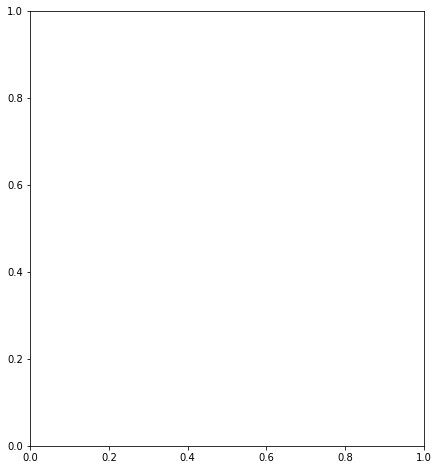

In [7]:
# Profondeur souhaitée de l'arbre de décision
profondeur = 5
# Nombres d'arbres dans la forêt
nombre_arbre = 15
# Règles sur une seule ou sur deux caractéristiques à la fois
nombre_var = 1 # 1 ou 2 
# Critère de séparation : 'gini' ou 'entropy'
critere = 'gini'
# Nombre minimal d'exemples dans une feuille
min_par_feuille = 2

# Définir le modèle
model = ...
plotClassifier("Forêt Aléatoire",  model, datasets)


## 4. AdaBoost

AdaBoost utilise également un ensemble d'arbres de décision, mais qui sous-apprennent (ils ont une profondeur de 1 par défaut).

[`sklearn.ensemble.AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Voici les paramètres auxquels nous devons faire attention lorsque nous construisons un modèle AdaBoost:
- `n_estimators` : le nombre d'arbres utilisés;
- `learning_rate` : le taux d'apprentissage, c.-à-d. la variation sur le poids des exemples mal classés.

**Exercice :**  En utilisant le constructeur `AdaBoostClassifier()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

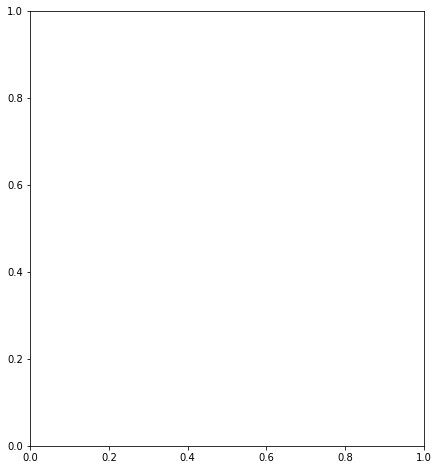

In [8]:
# Nombres d'arbres boosters
nombre_arbre = 10
# Taux d'apprentissage 
alpha = 0.5

# Définir le modèle
model = ...
plotClassifier("AdaBoost", model, datasets)

## 5. Gradient Boosting

Gradient Boosting est une version généralisée d'AdaBoost. 

[`sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Les paramètres auxquels nous devons faire attention sont les mêmes que lorsque nous construisons un modèle AdaBoost :
- `n_estimators` : le nombre d'arbres utilisés;
- `learning_rate` : le taux d'apprentissage, c.-à-d. la variation sur le poids des exemples mal classés;

Auxquels ont peut ajouter: 
- `subsample` : La fraction d'exemples à utiliser pour ajuster les classificateurs (`bootstraping`). Si inférieur à 1.0, l'algorithme devient du [`Stochastic Gradient Boosting`](https://en.wikipedia.org/wiki/Gradient_boosting#Stochastic_gradient_boosting).

**Exercice :**  En utilisant le constructeur `GradientBoostingClassifier()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

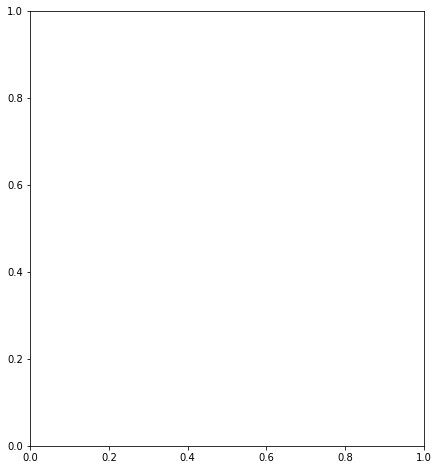

In [9]:
# Nombres d'arbres boosters
nombre_arbre = 15
# Taux d'apprentissage 
alpha = 0.1
# Profondeur souhaitée de l'arbre de décision
profondeur = 5
# Fraction des exemples
fraction = 1.0

# Définir le modèle
model = ...
plotClassifier("Boosting de gradient",  model, datasets)

## 6. Régression logistique

Ou comment faire de la régression linéaire avec des classes.

[`sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Les principaux paramètres de la régression logistique sont les suivants:
- `penalty` : La norme ($L_1$ ou $L_2$) utilisée pour calculer la fonction de perte;
- `max_iter` : Nombre maximal d'itérations ;
- `C` : Le paramètre inverse de régularisation dans $]0,1]$, plus `C` est proche de 0, plus la régularisation est forte.

On remarque que pour ces datasets, la capacité simple du classificateur n'est pas suffisante, il faudrait faire une projection dans l'espace des caractéristiques pour augmenter sa capacité et ainsi améliorer l'exactitude.

**Exercice :**  En utilisant le constructeur `LogisticRegression()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

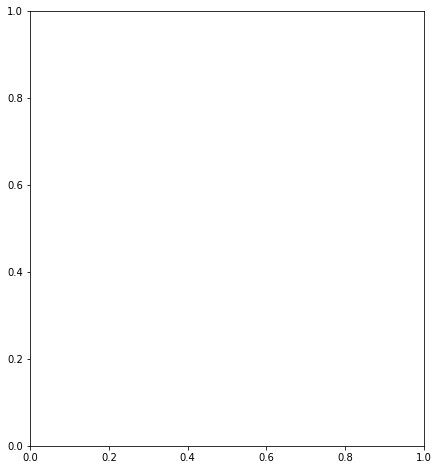

In [10]:
# Pénalité = 'l1' ou 'l2'
pénalité = 'l2' # ou 'l1'
# Nombre d'itérations pour s'assurer de la convergence, si un warning apparaît, c'est généralement à cause de ça.
iterations = 100
# Régularisation inverse ]0,1]
ireg = 1

# Définir le modèle
model = ...
plotClassifier("Regression Logistique", model, datasets)

## 7. Perceptron multi-couches

[`sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Les principaux paramètres du perceptron sont les suivants:
- `hidden_layer_sizes` : Le nombre de neurones sur la (ou les) couche(s) cachée(s).
- `activation` : La fonction d'activation de chaque neurone.
- `alpha` : Taux de régularisation $L_2$ sur les poids.
- `max_iter`,`tol` : `max_iter` est le nombre d'itérations avant d'arrêter si on ne souhaite pas attendre la convergence définie par la tolérance `tol` ( = 0.0001 par défaut).


**Exercice :**  En utilisant le constructeur `MLPClassifier()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

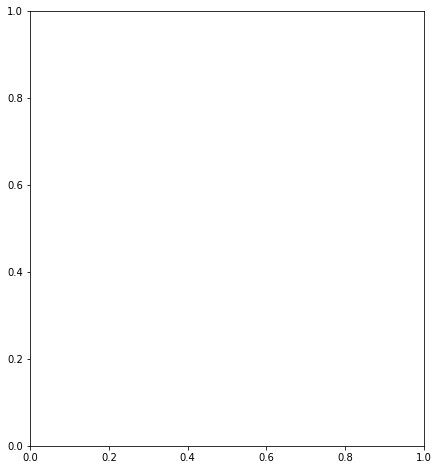

In [11]:
# Taux de régularisation (valeur par défaut à 0.0001)
regu = 0.01
# Nombre d'itérations pour s'assurer de la convergence, si un warning apparaît, c'est généralement à cause de ça.
iterations = 2000

# Nombre de neurones sur la (ou les) couche(s) cachée(s), une valeur par couche. 
# Par exemple (5,) signifie une seule couche cachée de 5 neurones. (5,3) signifie deux couches cachées une avec 5 l'autre avec 3.
taille = (5,)
# Fonction d'activation : ‘identity’, ‘logistic’, ‘tanh’, ‘relu’
activ = 'relu'

# Définir le modèle
model = ...
plotClassifier("Perceptron Multi-Couches",  model, datasets)

## 8. Support Vector Machines (SVM)

Ou machines à vecteurs de support (avec noyau linéaire ou gaussien).

[`sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Les principaux paramètres du SVM sont les suivants:
- `kernel` : le noyau à utiliser pour la mesure de distance;
- `C` :  facteur de régularisation des vecteurs de support;
- `max_iter`,`tol` : `max_iter` est le nombre d'itérations avant d'arrêter si on ne souhaite pas attendre la convergence définie par la tolérance `tol` ( = 0.001 par défaut).

**Exercice :**  En utilisant le constructeur `SVC()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

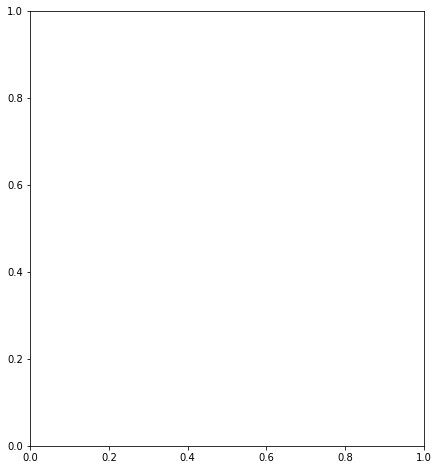

In [12]:
# Taux de régularisation (defaut à 0.0001)
regu= .1
# Noyau utilisé pour la transformation d'espace : 'linear', 'poly' (de degré 3 par défaut), 'rbf', 'sigmoid'
noyau = 'rbf'
# Nombre d'itérations pour s'assurer de la convergence, si un warning apparaît, c'est généralement à cause de ça.
iterations = 2000

# Définir le modèle
model = ...
plotClassifier("SVM avec noyau "+noyau, model, datasets)


## 9. Processus gaussien

[`sklearn.gaussian_process.GaussianProcessClassifier(kernel=None, optimizer=’fmin_l_bfgs_b’, n_restarts_optimizer=0, max_iter_predict=100, warm_start=False, copy_X_train=True, random_state=None, multi_class=’one_vs_rest’, n_jobs=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)

Le principal paramètre du processus gaussien est le `kernel` c.-à-d. le noyau à utiliser pour la mesure de distance. On pourra essayer les différents noyaux définis dans le code.
Il ne sera pas nécessaire d'optimiser les hyperparamètres du noyau puisque l'apprentissage s'en occupe.

Voici la documentation des différents noyaux : 
- [Constant](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html#sklearn.gaussian_process.kernels.ConstantKernel)
- [Dot product](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html#sklearn.gaussian_process.kernels.DotProduct)
- [RBF](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF)
- [Matern](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern) : RBF généralisé
- [Rational Quadratic](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic) : mixture infinie de RBF

**Exercice :**  En utilisant le constructeur `GaussianProcessClassifier()`, définissez le modèle avec différentes valeurs d'hyperparamètres. Essayez plusieurs combinaisons d'hyperparamètres afin de comprendre leur influence sur le résultat. N'hésitez pas à partager vos conclusions sur le forum.


AttributeError: 'ellipsis' object has no attribute 'fit'

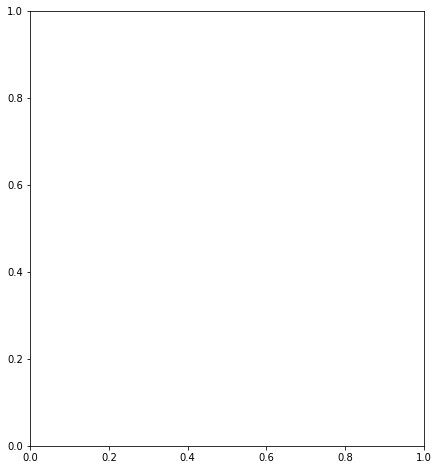

In [13]:
# noyauRBF_isotropique = 1.0 * RBF([1.0])
# noyauRBF_anisotropique = 1.0 * RBF([1.0, 1.0])

noyauRBF = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
noyauRQ = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
noyauDP = ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)
noyauM = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.0)

# Définir le modèle
model = ...
plotClassifier("Processus gaussien",  model, datasets)


## À vous de jouer

En utilisant le jeu de données Titanic (de Kaggle), déterminez quel modèle permet de mieux prédire la survie d'un passager.
Gardez à l'esprit : 

1. C'est de la classification binaire (oui/non)
2. Les données n'ont pas été préparées (cf. [Module 0](./Module_0_Coll_Prep.ipynb))
3. L'ensemble de données est déjà découpé entraînement/test
4. Il vous faudra valider parmi plusieurs modèles avec plusieurs hyperparamètres. Il vous faut donc un ensemble de validation (ou bien plusieurs si vous souhaitez faire de la validation croisée).

Mentionnez ensuite sur le forum quel a été le meilleur modèle appris, ainsi que ses hyperparamètres optimaux afin que d'autres participants puissent reproduire vos résultats. 

Évitez de donner du code sur le forum pour laisser la possibilité à chacun de trouver par soi-même ;-) 


In [14]:
import wget
 
!rm './titanic_train.csv' './titanic_test.csv'

wget.download('https://raw.githubusercontent.com/iid-ulaval/EEAA-datasets/master/titanic_train.csv','./titanic_train.csv')
wget.download('https://raw.githubusercontent.com/iid-ulaval/EEAA-datasets/master/titanic_test.csv','./titanic_test.csv')

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


100% [..............................................................................] 23887 / 23887

'./titanic_test (1).csv'